# Factor Research 

for FnGuide Application

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from pprint import pprint as pp

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel

In [3]:
cwd = Path.cwd()
data_dir = cwd / "data"
fnguide_dir = data_dir / "fnguide"
kqdl_dir = data_dir / "kqdl"
navernews_dir = data_dir / "navernews" / "navernews"

## 1. Import Dataset

학교에서 추출한 DataGuide 파일들을 불러오기

추출할 때 기간 내 delisted 종목도 포함시켰기 때문에 survivorship bias 적음.

In [4]:
## 추출한 fnguide 데이터를 dataframe으로 전처리

def preprocess_dataguide_csv(fn_file_name, cols, skiprows=8):
    fn_df = pd.read_csv(fnguide_dir / fn_file_name, encoding="cp949", skiprows=skiprows, thousands=",")
    fn_df = fn_df.melt(id_vars=cols, var_name="date", value_name="value")

    return fn_df

In [5]:
fn_file_names = [
    'dataguide_kse+kosdaq_20140101-20231215_stc_pricevolume.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_stc_mktcap.CSV',
    'dataguide_kse+kosdaq_20140101-20231219_foreigner.CSV',
]

In [6]:
## 날짜가 아닌 컬럼들

cols = ['Symbol', 'Symbol Name', 'Kind', 'Item', 'Item Name ', 'Frequency',]

In [7]:
pricevolume_df = preprocess_dataguide_csv(fn_file_names[0], cols)
mktcap_df = preprocess_dataguide_csv(fn_file_names[1], cols)
foreigner_df = preprocess_dataguide_csv(fn_file_names[2], cols)

In [8]:
pricevolume_df['Item Name '].unique()

array(['수익률(%)', '수정주가(원)', '수정저가(원)', '수정고가(원)', '수정시가(원)', '거래량(주)',
       '거래대금(원)'], dtype=object)

In [9]:
mktcap_df['Item Name '].unique()

array(['시가총액 (티커-상장예정주식수 미포함)(백만원)'], dtype=object)

In [10]:
foreigner_df['Item Name '].unique()

array(['외국인보유비중(티커)(%)'], dtype=object)

In [11]:
pricevolume_df.info() # 원래 값이 "10,000" 와 같이 comma seperated string number로 되어있었음. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92848805 entries, 0 to 92848804
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Symbol       object 
 1   Symbol Name  object 
 2   Kind         object 
 3   Item         object 
 4   Item Name    object 
 5   Frequency    object 
 6   date         object 
 7   value        float64
dtypes: float64(1), object(7)
memory usage: 5.5+ GB


## 2. Transform dataset

퀀트 분석을 위한 panel 형태로 변환

In [12]:
def get_panel_df(df, item_name):
    panel_df = df.loc[df['Item Name '] == item_name].copy()
    panel_df = panel_df.pivot(index='date', columns='Symbol', values='value')
    panel_df = panel_df.reset_index()
    
    return panel_df

In [13]:
def transform_panel(panel_df, remove_holidays=True, drop_sid_prefix=False):
    panel_df = panel_df.set_index('date', inplace=False)
    panel_df.sort_index(inplace=True)

    if drop_sid_prefix:
        panel_df.columns = [sid[1:] for sid in panel_df.columns]

    if remove_holidays:
        panel_df = panel_df.dropna(how='all', axis=0)
    
    return panel_df

In [14]:
return_2d = transform_panel(get_panel_df(pricevolume_df, '수익률(%)'))
tradingmoneyvolume_2d = transform_panel(get_panel_df(pricevolume_df, '거래대금(원)'))
mktcap_2d = transform_panel(get_panel_df(mktcap_df, '시가총액 (티커-상장예정주식수 미포함)(백만원)'))
foreigner_2d = transform_panel(get_panel_df(foreigner_df, '외국인보유비중(티커)(%)'))


In [15]:
return_2d.tail(10)

Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2023-12-01,NaN,-0.84,NaN,-0.20,-0.35,NaN,0.00,1.58,NaN,0.33,...,0.23,10.10,2.36,0.00,0.00,NaN,1.66,-1.34,-0.50,0.73
2023-12-04,NaN,-0.85,NaN,1.38,1.05,NaN,0.14,1.34,NaN,-0.98,...,0.57,-1.48,0.32,-1.02,-0.51,NaN,1.45,2.13,-1.32,5.12
2023-12-05,NaN,2.14,NaN,0.19,-0.57,NaN,0.00,0.22,NaN,3.94,...,-1.35,26.23,2.93,-0.91,-1.55,NaN,-0.18,0.95,-0.82,7.81
2023-12-06,NaN,0.52,NaN,-2.72,1.85,NaN,0.14,0.66,NaN,1.42,...,1.37,-6.62,-0.69,-1.15,-2.09,NaN,8.94,0.56,-0.10,-0.75
2023-12-07,NaN,3.23,NaN,-0.60,-1.02,NaN,-1.58,0.00,NaN,2.02,...,0.56,-0.54,-1.63,-0.12,-1.20,NaN,-3.12,0.93,-1.66,1.29
2023-12-08,NaN,-0.30,NaN,1.00,0.92,NaN,0.88,-0.22,NaN,0.46,...,-0.45,-4.57,2.36,0.00,1.08,NaN,-1.27,1.30,0.53,-0.40
2023-12-11,NaN,-0.10,NaN,-0.20,0.23,NaN,0.43,1.09,NaN,-0.61,...,-0.23,-5.26,4.54,1.17,0.40,NaN,5.58,-1.83,0.00,-1.56
2023-12-12,NaN,0.71,NaN,0.20,-0.91,NaN,-0.86,0.65,NaN,0.15,...,6.67,-1.11,-3.46,-0.92,0.80,NaN,-4.31,1.49,1.57,-1.59
2023-12-13,NaN,-1.31,NaN,-0.99,0.69,NaN,-1.02,0.00,NaN,-1.53,...,3.92,-6.03,-0.91,-0.47,-0.93,NaN,-0.68,-5.50,-1.03,-1.67


In [16]:
# Make checkpoint

return_2d.to_pickle(fnguide_dir / 'return_2d.pkl')
tradingmoneyvolume_2d.to_pickle(fnguide_dir / 'tradingmoneyvolume_2d.pkl')
mktcap_2d.to_pickle(fnguide_dir / 'mktcap_2d.pkl')
foreigner_2d.to_pickle(fnguide_dir / 'foreigner_2d.pkl')

## 3. Universe Filtering 

현실적인 포트폴리오 백테스팅을 위해 유동성 상위 2000 종목으로만 구성된 유니버스를 구성

In [17]:
START_DATE = '2014-01-01'
END_DATE = '2022-05-31' # news dataset은 여기까지 있음. 

SUBUNIVERSE = 2000

In [18]:
tradingmoneyvolume_2d.index

Index(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08',
       '2014-01-09', '2014-01-10', '2014-01-13', '2014-01-14', '2014-01-15',
       ...
       '2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
       '2023-12-08', '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14'],
      dtype='object', name='date', length=2450)

In [22]:
liquidity_rank_2d = tradingmoneyvolume_2d.rank(axis=1, method='dense', ascending=False)
univ2000_2d = liquidity_rank_2d <= SUBUNIVERSE

In [24]:
univ2000_2d.tail()

Symbol,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A950110,A950130,A950140,A950160,A950170,A950180,A950190,A950200,A950210,A950220
date,,,,,,,,,,,,,,,,,,,,,
2023-12-08,False,True,False,False,False,False,True,True,False,True,...,False,True,True,True,True,False,True,True,True,True
2023-12-11,False,True,False,False,False,False,True,True,False,True,...,False,True,True,True,False,False,True,True,True,True
2023-12-12,False,True,False,False,False,False,True,True,False,True,...,True,True,True,True,False,False,True,False,True,True
2023-12-13,False,True,False,False,False,False,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True
2023-12-14,False,True,False,True,False,False,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True


In [25]:
# 모든 데이터셋에 univ2000 mask 적용

return_2d = return_2d.loc[START_DATE:END_DATE][univ2000_2d]
tradingmoneyvolume_2d = tradingmoneyvolume_2d.loc[START_DATE:END_DATE][univ2000_2d]
mktcap_2d = mktcap_2d.loc[START_DATE:END_DATE][univ2000_2d]
foreigner_2d = foreigner_2d.loc[START_DATE:END_DATE][univ2000_2d]


In [35]:
return_2d = return_2d * 0.01 # % -> decimal

In [29]:
return_2d.shape

(2069, 3649)

## 4. Factor Portfolio 

Fama-French 3 Factor Portfolio를 만들어 단순 시가총액 가중 포트폴리오(벤치마크)와 수익률 비교

### A. Market factor

$$ R_m - R_f $$ 

`Rf`는 기준금리 series 데이터가 따로 필요하므로 일단 상수로 가정

이 경우 Sharpe 지수는 신뢰하기 어렵게 됨.

In [36]:
RISK_FREE = 0.04 / 252 # 1년 4% 수익률을 252일로 나눔

In [37]:
cap_weight = mktcap_2d.div(mktcap_2d.sum(axis=1), axis=0)
Rm = (return_2d - RISK_FREE).mul(cap_weight).sum(axis=1)

In [40]:
Rm.index = pd.to_datetime(Rm.index)

<Axes: title={'center': 'Market Factor Portfolio'}, xlabel='date'>

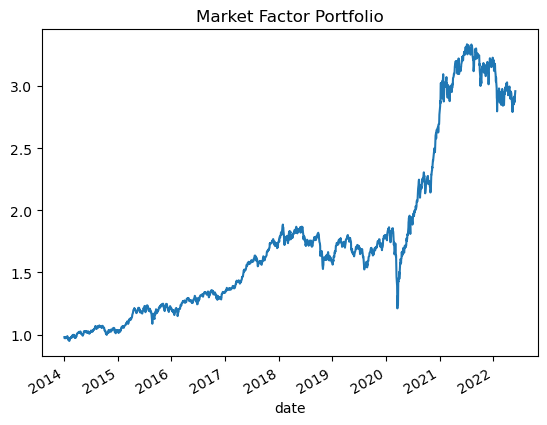

In [45]:
(1+Rm).cumprod().plot(title='Market Factor Portfolio')

### B. HML

High Minus Low

$$
\text{HML} = \frac{1}{2} \left( (S_{\text{low}} + B_{\text{low}}) - (S_{\text{high}} + B_{\text{high}}) \right)
$$

### C. SMB

Small Minus Big

$$
\text{SMB} = \frac{1}{3} \left( (S_{\text{low}} + S_{\text{mid}} + S_{\text{high}}) - (B_{\text{low}} + B_{\text{mid}} + B_{\text{high}}) \right)

$$

## 5. Factor Portfolio 성과분석 상세

`quantstats` 이용